# **Packages needed**

In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# **Data needed**

In [2]:
dat_df = pd.read_csv('dat_df.csv')

print(dat_df.head())


         Date  High   Low  Open  Close  Volume
0  06/03/2025  7.94  7.94  7.94   7.94       0
1  05/03/2025  7.96  7.80  7.96   7.94     400
2  04/03/2025  8.15  7.85  8.15   7.85     800
3  03/03/2025  7.80  7.68  7.80   7.68     300
4  28/02/2025  7.68  7.60  7.67   7.60     800


In [3]:
# View basic information
print(dat_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1500 non-null   object 
 1   High    1500 non-null   float64
 2   Low     1500 non-null   float64
 3   Open    1500 non-null   float64
 4   Close   1500 non-null   float64
 5   Volume  1500 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 70.4+ KB
None


In [4]:
# Change all to datetimelike
dat_df['Date'] = pd.to_datetime(dat_df['Date'], dayfirst=True)

# View one of them to recheck
dat_df.head()

,Date,High,Low,Open,Close,Volume
0,2025-03-06,7.94,7.94,7.94,7.94,0
1,2025-03-05,7.96,7.80,7.96,7.94,400
2,2025-03-04,8.15,7.85,8.15,7.85,800
3,2025-03-03,7.80,7.68,7.80,7.68,300
4,2025-02-28,7.68,7.60,7.67,7.60,800


In [5]:
# Reverse the datasets
dat_df = dat_df.iloc[::-1]

# View one of them to recheck
dat_df.head()

,Date,High,Low,Open,Close,Volume
1499,2019-03-06,18.5,17.25,18.5,17.25,50
1498,2019-03-07,17.0,17.00,17.0,17.00,100
1497,2019-03-08,17.0,17.00,17.0,17.00,0
1496,2019-03-11,17.0,17.00,17.0,17.00,0
1495,2019-03-12,15.9,15.85,15.9,15.85,20


## **Technical indicators**

In [6]:
# Calculate simple moving average
dat_df['SMA_200'] = dat_df['Close'].rolling(window = 200).mean()

# Drop all empty rows
dat_df.dropna(inplace = True)

# View one to check
dat_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200
1300,2019-12-17,16.30,16.30,16.30,16.30,0,17.20975
1299,2019-12-18,17.35,17.35,17.35,17.35,10,17.21025
1298,2019-12-19,17.35,17.35,17.35,17.35,0,17.21200
1297,2019-12-20,17.35,17.35,17.35,17.35,0,17.21375
1296,2019-12-23,17.35,17.35,17.35,17.35,0,17.21550


In [7]:
# Calculate RSI
dat_df['RSI'] = ta.momentum.RSIIndicator(dat_df['Close'].squeeze(), window = 14).rsi()

# View one to check
dat_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200,RSI
1300,2019-12-17,16.30,16.30,16.30,16.30,0,17.20975,NaN
1299,2019-12-18,17.35,17.35,17.35,17.35,10,17.21025,NaN
1298,2019-12-19,17.35,17.35,17.35,17.35,0,17.21200,NaN
1297,2019-12-20,17.35,17.35,17.35,17.35,0,17.21375,NaN
1296,2019-12-23,17.35,17.35,17.35,17.35,0,17.21550,NaN


In [8]:
# Calculate stochastic oscillator
dat_df['STOCH'] = ta.momentum.StochasticOscillator(high = dat_df['High'], low = dat_df['Low'], close = dat_df['Close'], window = 14).stoch()

# View one to see
dat_df.head()

,Date,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH
1300,2019-12-17,16.30,16.30,16.30,16.30,0,17.20975,NaN,NaN
1299,2019-12-18,17.35,17.35,17.35,17.35,10,17.21025,NaN,NaN
1298,2019-12-19,17.35,17.35,17.35,17.35,0,17.21200,NaN,NaN
1297,2019-12-20,17.35,17.35,17.35,17.35,0,17.21375,NaN,NaN
1296,2019-12-23,17.35,17.35,17.35,17.35,0,17.21550,NaN,NaN


In [9]:
# Drop all null columns
dat_df.dropna(inplace = True)

# Filter to get only from 2020-01-22 to 2025-01-14
dat_df = dat_df[(dat_df['Date'] >= '2020-01-22') & (dat_df['Date'] <= '2025-01-14')]

# And set date to be index
dat_df.set_index('Date', inplace = True)

# View one to check
dat_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH
Date,,,,,,,,
2020-01-31,18.55,18.55,18.55,18.55,10,17.11625,100.0,100.0
2020-02-03,18.55,18.55,18.55,18.55,0,17.11400,100.0,100.0
2020-02-04,18.55,18.55,18.55,18.55,0,17.11175,100.0,100.0
2020-02-05,18.55,18.55,18.55,18.55,0,17.10700,100.0,100.0
2020-02-06,18.55,18.55,18.55,18.55,0,17.10900,100.0,100.0


# **Add more data**

In [10]:
# Add GDP data in
gdp = pd.read_csv('gdp.csv', parse_dates=["Quarter"])
gdp

,Quarter,%Growth
0,Q1 2020,3.21
1,Q2 2020,0.39
2,Q3 2020,2.69
3,Q4 2020,4.48
4,Q1 2021,4.72
5,Q2 2021,6.73
6,Q3 2021,-6.02
7,Q4 2021,5.22
8,Q1 2022,5.05
9,Q2 2022,7.99


In [11]:
# Convert quarter of GDP dataset back to datetimelike
gdp['Quarter'] = gdp['Quarter'].astype(str)
gdp['Quarter'] = gdp['Quarter'].str.replace('Q1', '-01-01', regex=True)\
                                .str.replace('Q2', '-04-01', regex=True)\
                                .str.replace('Q3', '-07-01', regex=True)\
                                .str.replace('Q4', '-10-01', regex=True)

In [12]:
gdp['Quarter'] = pd.to_datetime(gdp['Quarter'], errors='coerce')
gdp

,Quarter,%Growth
0,2020-01-01,3.21
1,2020-04-01,0.39
2,2020-07-01,2.69
3,2020-10-01,4.48
4,2021-01-01,4.72
5,2021-04-01,6.73
6,2021-07-01,-6.02
7,2021-10-01,5.22
8,2022-01-01,5.05
9,2022-04-01,7.99


In [13]:
# Convert quarterly % growth to decimal
gdp['%Growth'] = gdp['%Growth'] / 100

# Create a full daily date range
daily_dates = pd.date_range(start = dat_df.index.min(), end = dat_df.index.max(), freq = 'D')
gdp_daily = pd.DataFrame({'Date': daily_dates})

# Merge and forward-fill quarterly growth rates
gdp_daily = gdp_daily.merge(gdp, left_on = 'Date', right_on = 'Quarter', how = 'left')
gdp_daily['%Growth'] = gdp_daily['%Growth'].bfill().ffill()

# Calculate daily growth rate assuming continuous compounding
gdp_daily['Daily growth'] = np.log(1 + gdp_daily['%Growth']) / 90

# Apply cumulative growth from a base value
gdp_daily['GDP_Index'] = 100 * np.exp(gdp_daily['Daily growth'].cumsum())

gdp_daily

,Date,Quarter,%Growth,Daily growth,GDP_Index
0,2020-01-31,NaT,0.0039,0.000043,100.004325
1,2020-02-01,NaT,0.0039,0.000043,100.008650
2,2020-02-02,NaT,0.0039,0.000043,100.012976
3,2020-02-03,NaT,0.0039,0.000043,100.017301
4,2020-02-04,NaT,0.0039,0.000043,100.021627
...,...,...,...,...,...
1806,2025-01-10,NaT,0.0755,0.000809,284.819317
1807,2025-01-11,NaT,0.0755,0.000809,285.049752
1808,2025-01-12,NaT,0.0755,0.000809,285.280374
1809,2025-01-13,NaT,0.0755,0.000809,285.511182


In [14]:
# We use GDP index
gdp_daily = gdp_daily[['Date', 'GDP_Index']]
gdp_daily.set_index('Date', inplace = True)

# Merge this with 6 datasets
dat_df = dat_df.merge(gdp_daily, left_index = True, right_index = True)

# View one to check
dat_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH,GDP_Index
Date,,,,,,,,,
2020-01-31,18.55,18.55,18.55,18.55,10,17.11625,100.0,100.0,100.004325
2020-02-03,18.55,18.55,18.55,18.55,0,17.11400,100.0,100.0,100.017301
2020-02-04,18.55,18.55,18.55,18.55,0,17.11175,100.0,100.0,100.021627
2020-02-05,18.55,18.55,18.55,18.55,0,17.10700,100.0,100.0,100.025953
2020-02-06,18.55,18.55,18.55,18.55,0,17.10900,100.0,100.0,100.030279


## **Interest rates**

In [15]:
ir = pd.read_excel('ir.xlsx')
ir.head()

,Date,%
0,2020-01-31,6.0
1,2020-02-29,6.0
2,2020-03-17,5.0
3,2020-04-30,5.0
4,2020-05-12,4.5


In [16]:
ir['Date'] = pd.to_datetime(ir['Date'])
ir.rename(columns={"%": "Interest rates"}, inplace=True)
# Create a full daily date range from min to max date
daily_dates = pd.date_range(start=dat_df.index.min(), end=dat_df.index.max(), freq="D")
daily_ir = pd.DataFrame({"Date": daily_dates})

# Merge and forward-fill quarterly growth rates
daily_ir = daily_ir.merge(ir, on = 'Date', how="left")

# Calculate daily growth rate assuming continuous compounding
daily_ir['Interest rates'] = daily_ir['Interest rates'].interpolate(method = 'linear')
daily_ir['Interest rates'] = daily_ir['Interest rates'].fillna(method = 'bfill')

daily_ir

,Date,Interest rates
0,2020-01-31,6.0
1,2020-02-01,6.0
2,2020-02-02,6.0
3,2020-02-03,6.0
4,2020-02-04,6.0
...,...,...
1806,2025-01-10,4.5
1807,2025-01-11,4.5
1808,2025-01-12,4.5
1809,2025-01-13,4.5


In [17]:
# Merge with 6 datasets
daily_ir.set_index('Date', inplace = True)

dat_df = dat_df.merge(daily_ir, left_index = True, right_index = True)

# View one to see
dat_df.head()

,High,Low,Open,Close,Volume,SMA_200,RSI,STOCH,GDP_Index,Interest rates
Date,,,,,,,,,,
2020-01-31,18.55,18.55,18.55,18.55,10,17.11625,100.0,100.0,100.004325,6.0
2020-02-03,18.55,18.55,18.55,18.55,0,17.11400,100.0,100.0,100.017301,6.0
2020-02-04,18.55,18.55,18.55,18.55,0,17.11175,100.0,100.0,100.021627,6.0
2020-02-05,18.55,18.55,18.55,18.55,0,17.10700,100.0,100.0,100.025953,6.0
2020-02-06,18.55,18.55,18.55,18.55,0,17.10900,100.0,100.0,100.030279,6.0


In [18]:
# Drop unnecessary columns
dat_df.drop(['High', 'Low', 'Open', 'Volume'], axis = 1, inplace = True)

dat_df.head()

,Close,SMA_200,RSI,STOCH,GDP_Index,Interest rates
Date,,,,,,
2020-01-31,18.55,17.11625,100.0,100.0,100.004325,6.0
2020-02-03,18.55,17.11400,100.0,100.0,100.017301,6.0
2020-02-04,18.55,17.11175,100.0,100.0,100.021627,6.0
2020-02-05,18.55,17.10700,100.0,100.0,100.025953,6.0
2020-02-06,18.55,17.10900,100.0,100.0,100.030279,6.0


# **ARIMAX models**

In [19]:
# Define evaluation metrics
def calculate_accuracy(real, predict):
    return (1 - np.sqrt(np.mean(np.square((real - predict) / real)))) * 100

def evaluate_performance(real, predict):
    mse = mean_squared_error(real, predict)
    rmse = np.sqrt(mse)
    accuracy = calculate_accuracy(real, predict)
    return mse, rmse, accuracy

In [20]:
# Split data into train and test (80:20)
train_size = int(len(dat_df) * 0.8)
train, test = dat_df.iloc[:train_size], dat_df.iloc[train_size:]

# Define target variable and exogenous features
y_train, y_test = train['Close'], test['Close']
exog_train = train[['SMA_200', 'RSI', 'STOCH', 'GDP_Index', 'Interest rates']]
exog_test = test[['SMA_200', 'RSI', 'STOCH', 'GDP_Index', 'Interest rates']]

In [21]:
# Use auto_arima to find the best (p, d, q) order
auto_arima_model = auto_arima(y_train, exogenous=exog_train, seasonal=False, stepwise=True, suppress_warnings=True)
best_order = auto_arima_model.order
print(f"Best ARIMA Order: {best_order}")
print(auto_arima_model.summary())

Best ARIMA Order: (1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  994
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1369.915
Date:                Fri, 07 Mar 2025   AIC                           2745.831
Time:                        02:10:13   BIC                           2760.533
Sample:                             0   HQIC                          2751.420
                                - 994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7447      0.018     42.239      0.000       0.710       0.779
ma.L1         -0.4216      0.023    -18.579      0.000      -0.466      -0.377
sigma2         0.9240   

In [22]:
# Fit SARIMAX model using the best order
sarimax_model = SARIMAX(y_train, exog=exog_train, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit(disp=False)
# Print model summary
print(sarimax_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  994
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1037.495
Date:                Fri, 07 Mar 2025   AIC                           2090.991
Time:                        02:10:14   BIC                           2130.180
Sample:                             0   HQIC                          2105.892
                                - 994                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
SMA_200            3.1401      0.574      5.468      0.000       2.015       4.266
RSI                0.1187      0.003     35.010      0.000       0.112       0.125
STOCH              0.0014      0.002

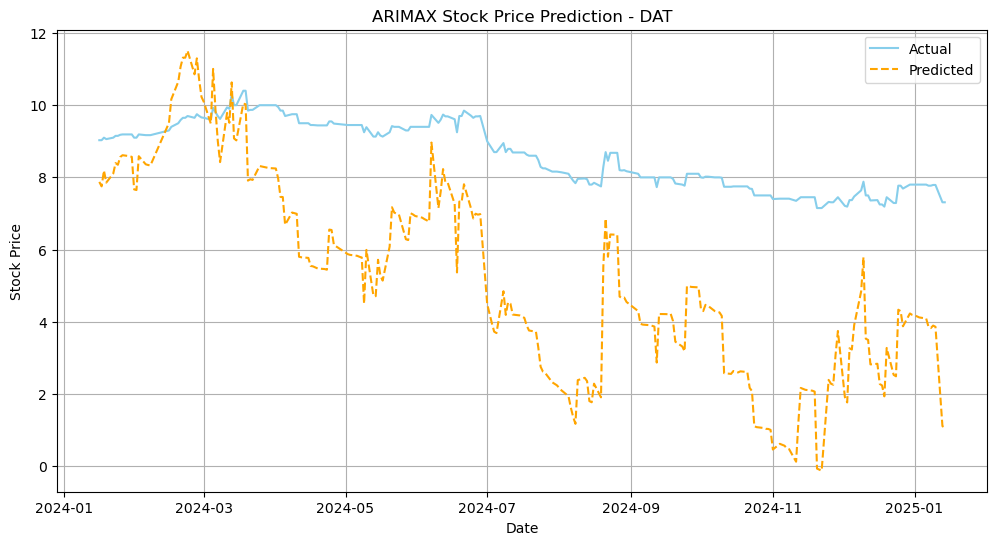

In [23]:
# Make predictions on the test set
predictions = sarimax_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_test)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label="Actual", color="skyblue")
plt.plot(test.index, predictions, label="Predicted", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMAX Stock Price Prediction - DAT")
plt.legend()
plt.grid()
plt.show()

In [24]:
predictions.index = y_test.index  # Assign y_test's index to predictions

In [25]:
# Evaluate performance
mse, rmse, accuracy = evaluate_performance(y_test, predictions)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

MSE: 16.06
RMSE: 4.01
Accuracy: 49.64%
